# Assemble image pathnames and understand class breakdown in dataset

In [1]:
import numpy as np
from glob import glob
import torch

# Check quantities of train, validation and test images
train_images = np.array(glob("data/train/*/*"))
valid_images = np.array(glob("data/valid/*/*"))
test_images = np.array(glob("data/test/*/*"))

# Check relative percentages of image types
train_images_mel = np.array(glob("data/train/melanoma/*"))
train_images_nev = np.array(glob("data/train/nevus/*"))
train_images_seb = np.array(glob("data/train/seborrheic_keratosis/*"))

valid_images_mel = np.array(glob("data/valid/melanoma/*"))
valid_images_nev = np.array(glob("data/valid/nevus/*"))
valid_images_seb = np.array(glob("data/valid/seborrheic_keratosis/*"))

test_images_mel = np.array(glob("data/test/melanoma/*"))
test_images_nev = np.array(glob("data/test/nevus/*"))
test_images_seb = np.array(glob("data/test/seborrheic_keratosis/*"))

print("There are {} training images, {} validation images and {} test images.".format(len(train_images),len(valid_images),len(test_images)))
print("For the training images, {mel:=.1f}% ({mel2}) are of melanoma, {nev:=.1f}% ({nev2}) are of nevus and {seb:=.1f}% ({seb2}) are for seborrheic keratosis.".format(mel=len(train_images_mel)/len(train_images)*100, mel2=len(train_images_mel),nev=len(train_images_nev)/len(train_images)*100, nev2=len(train_images_nev), seb=len(train_images_seb)/len(train_images)*100, seb2=len(train_images_seb)))
print("For the validation images, {mel:=.1f}% ({mel2}) are of melanoma, {nev:=.1f}% ({nev2}) are of nevus and {seb:=.1f}% ({seb2}) are for seborrheic keratosis.".format(mel=len(valid_images_mel)/len(valid_images)*100, mel2=len(valid_images_mel),nev=len(valid_images_nev)/len(valid_images)*100, nev2=len(valid_images_nev), seb=len(valid_images_seb)/len(valid_images)*100, seb2=len(valid_images_seb)))
print("For the test images, {mel:=.1f}% ({mel2}) are of melanoma, {nev:=.1f}% ({nev2}) are of nevus and {seb:=.1f}% ({seb2}) are for seborrheic keratosis.".format(mel=len(test_images_mel)/len(test_images)*100, mel2=len(test_images_mel),nev=len(test_images_nev)/len(test_images)*100, nev2=len(test_images_nev), seb=len(test_images_seb)/len(test_images)*100, seb2=len(test_images_seb)))

There are 2000 training images, 150 validation images and 600 test images.
For the training images, 18.7% (374) are of melanoma, 68.6% (1372) are of nevus and 12.7% (254) are for seborrheic keratosis.
For the validation images, 20.0% (30) are of melanoma, 52.0% (78) are of nevus and 28.0% (42) are for seborrheic keratosis.
For the test images, 19.5% (117) are of melanoma, 65.5% (393) are of nevus and 15.0% (90) are for seborrheic keratosis.


In [2]:
# Check for GPU support
use_cuda = torch.cuda.is_available()

# View random images to get a feel for what the dataset looks like

In [3]:
from PIL import Image 
import matplotlib.pyplot as plt                        
%matplotlib inline 

def plot_some_imgs(num_imgs_to_plot,dataset,dataset_name):
    print("Plotting {} images from dataset {}".format(num_imgs_to_plot,dataset_name))
    fig = plt.figure(figsize = (10,num_imgs_to_plot*2))
    axes = []
    for i in range(num_imgs_to_plot):
        img = Image.open(dataset[np.random.randint(0,len(dataset)-1)])
        axes.append(fig.add_subplot(num_imgs_to_plot/2,2,i+1))
        axes[-1].imshow(img)

Plotting 10 images from dataset Training Images Melanoma


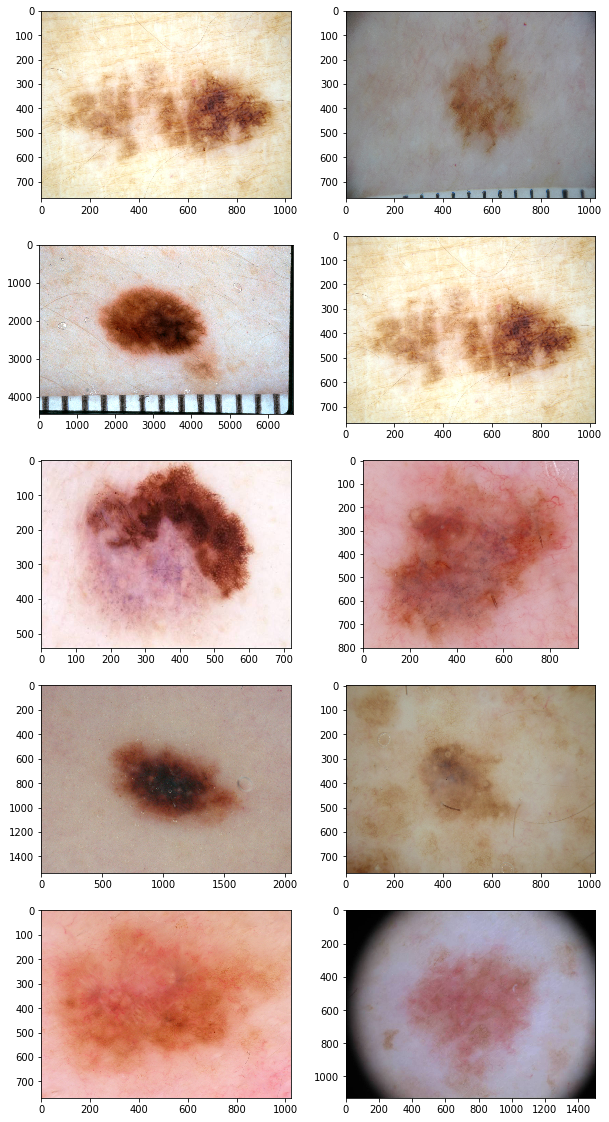

In [4]:
plot_some_imgs(10,train_images_mel,"Training Images Melanoma")

# Auto-optimization of model parameters + data loading/processing setup

In [5]:
# First take care of Pytorch imports
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
# Now handle imports needed for HPBANDSTER.
import os
import time
import pickle
import argparse
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres
from hpbandster.optimizers import BOHB
import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH
from hpbandster.core.worker import Worker
import logging
logging.basicConfig(level=logging.DEBUG)

In [6]:
def ISICNetAlex(num_new_fc_layers=0, new_layer_elements=[], dropout_rate=0.5, old_fclayers_tofreeze=[0,1]):
    # num_new_fc_layers -- There are 3 FC layers in Alexnet to begin with. The last layer gets replaced by default. 
    #                      A value of 1 here would add a fourth layer, whereas a value of 0 would just retool the last layer.
    # dropout_rate --      0<= dropout_rate < 1. Sets the dropout rate for each FC layer to this .value.
    # old_fclayers_to_freeze --  A set of indices with length <= 2. Must be a subset of [0,1]
    model = models.alexnet(pretrained=True)
    num_output_nodes = 3
    # Set these three params even though they're passed into the function because in this notebook I'm only looking at dropout and learning rate. 
    num_new_fc_layers = 0
    new_layer_elements = []
    old_fclayers_tofreeze = []
    
    # Input error checking
    
    # Can't have negative number of new layers.
    assert num_new_fc_layers >= 0
    # Dropout rate must be between 0 and 1
    assert 0 <= dropout_rate < 1
    # You have to specify the number of output elements for each additional layer you want.
    assert num_new_fc_layers == len(new_layer_elements)
    # Old layers to freeze must be picked from the following: [0,1]. All new layers and the last layer will be trained by necessity.
    checklayers = set(old_fclayers_tofreeze)
    assert checklayers.issubset([0,1])
    
    # Add the new layers. This will have the same structure as the existing fc layers.
    for i in range(num_new_fc_layers+1):
        # No dropout before the last layer.
        if i == num_new_fc_layers:
            model.classifier.add_module(str(6+i*3), nn.ReLU(inplace=True))
            model.classifier.add_module(str(6+i*3), nn.Linear(model.classifier[4+i*3].out_features,num_output_nodes,bias=True))
        else:
            model.classifier.add_module(str(6+i*3), nn.Dropout(dropout_rate))
            model.classifier.add_module(str(7+i*3), nn.Linear(model.classifier[7+(i-1)*3].out_features,new_layer_elements[i],bias=True))
            model.classifier.add_module(str(8+i*3), nn.ReLU(inplace=True))
            
             
    # Set requires_grad appropriately for the model.
    # First, set all requires_grad for all parameters in the features portion of the model to False.
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Now deal with the classifier.
    for i in range(len(old_fclayers_tofreeze)):
        if old_fclayers_tofreeze[i] == 0:
            for param in model.classifier[0].parameters():
                param.requires_grad = False
            for param in model.classifier[1].parameters():
                param.requires_grad = False
            for param in model.classifier[2].parameters():
                param.requires_grad = False
        if old_fclayers_tofreeze[i] == 1:
            for param in model.classifier[3].parameters():
                param.requires_grad = False
            for param in model.classifier[4].parameters():
                param.requires_grad = False
            for param in model.classifier[5].parameters():
                param.requires_grad = False
    
    #set dropout rate for all relevant layers.
    for i in range(len(model.classifier)):
        if type(model.classifier[i]) is torch.nn.modules.dropout.Dropout:
            model.classifier[i] = nn.Dropout(dropout_rate)
        
    
    
    # Print the model
    print(model)
        
    return model
    
    


def number_of_parameters(model):
        return(sum(p.numel() for p in model.parameters() if p.requires_grad))


In [7]:
# Define the worker
class worker(Worker):
    def __init__(self, N_train = 200, N_valid = len(valid_images), **kwargs):
            super().__init__(**kwargs)
            # Transforms, datasets and data loaders
            random_transforms = [transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.RandomAffine(degrees=45,translate=(0.1,0.3),scale=(0.5,2))]

            train_transforms = transforms.Compose([transforms.Resize(size=256),transforms.CenterCrop(224),transforms.RandomChoice(random_transforms), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

            valid_test_transforms = transforms.Compose([transforms.Resize(size=256),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
            
            # No data augmentation for the validation and test datasets, because we're using those as is for evaluation.
            
            random_transforms = [transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.RandomAffine(degrees=45,translate=(0.1,0.3),scale=(0.5,2))]

            train_transforms = transforms.Compose([transforms.Resize(size=256),transforms.CenterCrop(224),transforms.RandomChoice(random_transforms), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
            train_data = datasets.ImageFolder('data/train',transform=train_transforms)

            self.train_loader = torch.utils.data.DataLoader(train_data, batch_size = 32, drop_last=True, shuffle=True)
            
            validation_data = datasets.ImageFolder('data/valid',transform=valid_test_transforms)
            test_data = datasets.ImageFolder('data/test',transform=valid_test_transforms)
            

            self.validation_loader = torch.utils.data.DataLoader(validation_data, batch_size = 128)
            
            self.test_loader = torch.utils.data.DataLoader(test_data, batch_size = 128)
            
            
    def compute(self, config, budget, working_directory, *args, **kwargs):
        """
        The input parameter "config" (dictionary) contains the sampled configurations passed by the bohb optimizer
        """
        #TODO -- separate that out into a separate notebook and start it running on a small subset of what we ultimately want to etst
        #        . Then dig into results visualization, etc.
        #TODO -- figure out which is the most beastly GPU compute instance (or instances -- try cloud cluster) for training CNNs quickly. 
        #TODO -- get something built for computing on multiple GPUs and test it out.
        # Useful website -- https://aws.amazon.com/blogs/machine-learning/scalable-multi-node-deep-learning-training-using-gpus-in-the-aws-cloud/
        #TODO -- Try on the ISIC 2017 training set, see what we come up with.
        #TODO -- try on an augmented training set, see what we come up with. 
        #TODO -- do it for MM.
        
        
        #new_layer_elements = np.array([config['num_els_new_1'] if config['num_new_fc_layers'] >= 1 else None, 
        #                      config['num_els_new_2'] if config['num_new_fc_layers'] >= 2 else None, 
        #                      config['num_els_new_3'] if config['num_new_fc_layers'] >= 3 else None])
        
        #new_layer_elements = list(new_layer_elements[new_layer_elements != None])
        
        #old_fclayers_tofreeze = np.array([0 if config['freeze0_cat'] == 1 else None,
        #                        1 if config['freeze1_cat'] == 1 else None])
        
        #old_fclayers_tofreeze = list(old_fclayers_tofreeze[old_fclayers_tofreeze != None])
        
        model = ISICNetAlex(num_new_fc_layers=0,
                                                new_layer_elements=[],
                                                dropout_rate=config['dropout_rate'],
                                                old_fclayers_tofreeze=[],
        )

        if use_cuda:
            model.cuda()
        # Build criterion and optimizer.
        criterion = torch.nn.CrossEntropyLoss()
        #if config['optimizer'] == 'Adam':
        #    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
        #else:
        #    optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=config['sgd_momentum'])
        optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=config['sgd_momentum'])
        
        # Run training loop
        for epoch in range(int(budget)):
            start = time.time()
            # initialize variables to monitor training and validation loss
            train_loss = 0.0

            ###################
            # train the model #
            ###################
            model.train()
            for batch_idx, (data, target) in enumerate(self.train_loader):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                train_loss += 1/(batch_idx+1)*(loss.data-train_loss)

            print("Epoch {} training time took {} seconds".format(epoch,time.time()-start))

        train_accuracy = self.evaluate_accuracy(model, self.train_loader)
        validation_accuracy = self.evaluate_accuracy(model, self.validation_loader)
        test_accuracy = self.evaluate_accuracy(model, self.test_loader)

        return ({
                'loss': 1-validation_accuracy, # remember: HpBandSter always minimizes!
                'info': {       'test accuracy': test_accuracy,
                                        'train accuracy': train_accuracy,
                                        'validation accuracy': validation_accuracy,
                                        'number of parameters': number_of_parameters(model),
                                }

        })

    def evaluate_accuracy(self, model, data_loader):
        correct = 0
        total = 0
        model.eval()
        for batch_idx, (data, target) in enumerate(data_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model.forward(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
        #import pdb; pdb.set_trace()
        return(correct/total)


    @staticmethod
    def get_configspace():
        """
        It builds the configuration space with the needed hyperparameters.
        It is easily possible to implement different types of hyperparameters.
        Beside float-hyperparameters on a log scale, it is also able to handle categorical input parameter.
        :return: ConfigurationsSpace-Object
        """
        cs = CS.ConfigurationSpace()

        # Training batch size hyperparameter
        #batchsize = CSH.UniformIntegerHyperparameter('train_batch_size', lower=1, upper=128, default_value=32,log=True)

        # Learning rate hyperparameter
        lr = CSH.UniformFloatHyperparameter('lr', lower=1e-6, upper=1e-1, default_value='1e-2', log=True)

        # Optimizer hyperparameter.
        #optimizer = CSH.CategoricalHyperparameter('optimizer', ['Adam', 'SGD'])

        # Stochastic gradient descent momentum as parameter.
        sgd_momentum = CSH.UniformFloatHyperparameter('sgd_momentum', lower=0.0, upper=0.99, default_value=0.9, log=False)

        cs.add_hyperparameters([lr, sgd_momentum])
        #cs.add_hyperparameters([optimizer])

        # Only add the sgd_momentum hyperparameter if the optimizer is stochastic gradient descent. Otherwise, it doesn't make sense.
        #cond = CS.EqualsCondition(sgd_momentum, optimizer, 'SGD')
        #cs.add_condition(cond)


        #num_new_fc_layers =  CSH.UniformIntegerHyperparameter('num_new_fc_layers', lower=0, upper=3, default_value=0, log=False)
        #num_els_new_1 = CSH.UniformIntegerHyperparameter('num_els_new_1', lower=128, upper=4096, default_value = 1000, log=True)
        #num_els_new_2 = CSH.UniformIntegerHyperparameter('num_els_new_2', lower=128, upper=4096, default_value = 1000, log=True)
        #num_els_new_3 = CSH.UniformIntegerHyperparameter('num_els_new_3', lower=128, upper=4096, default_value = 1000, log=True)

        #freeze0_old = CSH.UniformIntegerHyperparameter('freeze0_cat', lower = 0, upper = 1, default_value = 1, log=False)
        #freeze1_old = CSH.UniformIntegerHyperparameter('freeze1_cat', lower=0, upper=1, default_value=1, log=False)

        #cs.add_hyperparameters([num_new_fc_layers, num_els_new_1, num_els_new_2, num_els_new_3, freeze0_old, freeze1_old, batchsize])

        dropout_rate = CSH.UniformFloatHyperparameter('dropout_rate', lower=0.0, upper=0.9, default_value=0.5, log=False)

        cs.add_hyperparameters([dropout_rate])

        return cs





In [8]:
# Define the parser
parser = argparse.ArgumentParser(description='ISIC2017 - CNN on Derm Dataset')
parser.add_argument('--min_budget',   type=float, help='Minimum number of epochs for training.',    default=1)
parser.add_argument('--max_budget',   type=float, help='Maximum number of epochs for training.',    default=3)
parser.add_argument('--n_iterations', type=int,   help='Number of iterations performed by the optimizer', default=16)
parser.add_argument('--worker', help='Flag to turn this into a worker process', action='store_true')
parser.add_argument('--run_id', type=str, help='A unique run id for this optimization run. An easy option is to use the job id of the clusters scheduler.')
parser.add_argument('--nic_name',type=str, help='Which network interface to use for communication.', default='lo')
parser.add_argument('--shared_directory',type=str, help='A directory that is accessible for all processes, e.g. a NFS share.', default='/home/ubuntu/src/derm-ai/data')
parser.add_argument('--backend',help='Toggles which worker is used. Choose between a pytorch and a keras implementation.', choices=['pytorch', 'keras'], default='pytorch')
args = parser.parse_args([])

In [9]:
host = hpns.nic_name_to_host(args.nic_name)
# This example shows how to log live results. This is most useful
# for really long runs, where intermediate results could already be
# interesting. The core.result submodule contains the functionality to
# read the two generated files (results.json and configs.json) and
# create a Result object.
result_logger = hpres.json_result_logger(directory=args.shared_directory, overwrite=True)
# Start a nameserver:
NS = hpns.NameServer(run_id=args.run_id, host=host, port=0, working_directory=args.shared_directory)
ns_host, ns_port = NS.start()



In [10]:
# Start local worker
w = worker(run_id=args.run_id, host=host, nameserver=ns_host, nameserver_port=ns_port, timeout=120)
w.run(background=True)

DEBUG:hpbandster.run_None.worker.ip-172-31-46-8.1946:WORKER: Connected to nameserver <Pyro4.core.Proxy at 0x7fc18f681940; connected IPv4; for PYRO:Pyro.NameServer@127.0.0.1:39413>
DEBUG:hpbandster.run_None.worker.ip-172-31-46-8.1946:WORKER: No dispatcher found. Waiting for one to initiate contact.
INFO:hpbandster.run_None.worker.ip-172-31-46-8.1946:WORKER: start listening for jobs


In [11]:
bohb = BOHB(  configspace = w.get_configspace(),
                      run_id = args.run_id,
                      host=host,
                      nameserver=ns_host,
                      nameserver_port=ns_port,
                      result_logger=result_logger,
                      min_budget=args.min_budget, max_budget=args.max_budget,
               )

INFO:hpbandster:DISPATCHER: started the 'discover_worker' thread
INFO:hpbandster:DISPATCHER: started the 'job_runner' thread
INFO:hpbandster:DISPATCHER: Pyro daemon running on 127.0.0.1:45539
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 0 currently in the pool.
INFO:hpbandster:DISPATCHER: discovered new worker, hpbandster.run_None.worker.ip-172-31-46-8.1946140471068530496
DEBUG:hpbandster:HBMASTER: number of workers changed to 1
DEBUG:hpbandster:DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
DEBUG:hpbandster:adjust_queue_size: lock accquired
INFO:hpbandster:HBMASTER: adjusted queue size to (0, 1)
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Trying to submit another job.
DEBUG:hpbandster:DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!


In [12]:
# Run an optimizer

res = bohb.run(n_iterations=args.n_iterations)
bohb.shutdown(shutdown_workers=True)
NS.shutdown()

DEBUG:hpbandster:wait_for_workers trying to get the condition
DEBUG:hpbandster:Enough workers to start this run!
INFO:hpbandster:HBMASTER: starting run at 1544457543.739372
DEBUG:hpbandster:start sampling a new configuration.
DEBUG:hpbandster:done sampling a new configuration.
DEBUG:hpbandster:HBMASTER: schedule new run for iteration 0
DEBUG:hpbandster:HBMASTER: trying submitting job (0, 0, 0) to dispatcher
DEBUG:hpbandster:HBMASTER: submitting job (0, 0, 0) to dispatcher
DEBUG:hpbandster:DISPATCHER: trying to submit job (0, 0, 0)
DEBUG:hpbandster:DISPATCHER: trying to notify the job_runner thread.
DEBUG:hpbandster:HBMASTER: job (0, 0, 0) submitted to dispatcher
DEBUG:hpbandster:DISPATCHER: Trying to submit another job.
DEBUG:hpbandster:HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
DEBUG:hpbandster:DISPATCHER: starting job (0, 0, 0) on hpbandster.run_None.worker.ip-172-31-46-8.1946140471068530496
DEBUG:hpbandster:DISPATCHER: job (0, 0, 0) dispatched on hpbandster.run_None.work

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.14046978984170552)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.14046978984170552)
    (4): Line

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 456.06304836273193 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.8305081517413093)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.8305081517413093)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 447.1634440422058 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.8199104253741688)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.8199104253741688)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 448.265460729599 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.8305081517413093)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.8305081517413093)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 451.7215619087219 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 450.5752031803131 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 450.34392952919006 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5752936429501725)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5752936429501725)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 451.5583667755127 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 449.5400903224945 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 449.4591906070709 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5244658784412328)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5244658784412328)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 448.449010848999 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 449.35557222366333 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 450.1635203361511 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.056792451843730885)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.056792451843730885)
    (4): Li

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 450.29279613494873 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.15429216767760162)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.15429216767760162)
    (4): Line

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 449.93202543258667 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.2909859705278714)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.2909859705278714)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 450.697146654129 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.2909859705278714)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.2909859705278714)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 449.10685086250305 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 449.66755390167236 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 450.00297498703003 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.7583915923704407)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.7583915923704407)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 449.2046728134155 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 450.9223110675812 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.7414345274577643)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.7414345274577643)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 447.53362703323364 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 450.3739447593689 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 449.804838180542 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.2980741968927345)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.2980741968927345)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 449.45163559913635 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.731085157945681)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.731085157945681)
    (4): Linear(i

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 449.7150721549988 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.4230084636593833)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.4230084636593833)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 449.81502079963684 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.731085157945681)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.731085157945681)
    (4): Linear(i

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 449.5007872581482 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 450.1663718223572 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 448.9246597290039 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.8132973278485265)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.8132973278485265)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 450.33284735679626 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 448.2051546573639 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 447.9979808330536 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.64898876681969)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.64898876681969)
    (4): Linear(in_

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 449.2734637260437 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 448.19090008735657 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 449.7091724872589 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.8655496199469936)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.8655496199469936)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 449.35370445251465 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.028042084125511412)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.028042084125511412)
    (4): Li

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 449.3772220611572 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.4556679652811188)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.4556679652811188)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 451.0620062351227 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.8655496199469936)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.8655496199469936)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 448.9399003982544 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 447.46019315719604 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 449.47251200675964 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.09232229608206736)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.09232229608206736)
    (4): Line

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 449.67105650901794 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 450.678626537323 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 448.6116909980774 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5315547789047641)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5315547789047641)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 447.80306696891785 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 448.28698563575745 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 449.71662163734436 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.06560879776571325)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.06560879776571325)
    (4): Line

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 450.9362323284149 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.06020461595912823)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.06020461595912823)
    (4): Line

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 450.1976935863495 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.19345745521429325)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.19345745521429325)
    (4): Line

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery


Epoch 0 training time took 452.0164451599121 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.06020461595912823)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.06020461595912823)
    (4): Line

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 448.27773880958557 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 447.56950664520264 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 450.58886671066284 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.028174686962800066)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.028174686962800066)
    (4): Li

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 450.2519152164459 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 450.13142013549805 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 450.57756781578064 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.21742310851074942)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.21742310851074942)
    (4): Line

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 451.42481231689453 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 449.1823000907898 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 449.4648621082306 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5631885241446716)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5631885241446716)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 450.7011466026306 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5576637524986489)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5576637524986489)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 451.10165905952454 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.17173512170084357)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.17173512170084357)
    (4): Line

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 450.0249307155609 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5576637524986489)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5576637524986489)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 451.38640880584717 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 449.29026889801025 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 450.8745756149292 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.1334894386208703)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.1334894386208703)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 441.4964680671692 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 442.7177014350891 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 442.725643157959 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.33244007813928095)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.33244007813928095)
    (4): Line

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 449.9839115142822 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 449.45364594459534 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 449.049045085907 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.2302495859906555)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.2302495859906555)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 450.0652723312378 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.860253345291744)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.860253345291744)
    (4): Linear(i

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 450.9773168563843 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.7582556432031369)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.7582556432031369)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 451.20867562294006 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.2302495859906555)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.2302495859906555)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 451.2131781578064 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 449.2767026424408 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 448.7360837459564 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.8543864887680015)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.8543864887680015)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 451.1096725463867 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 449.2663531303406 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 450.131876707077 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.8209588839484488)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.8209588839484488)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 450.8129081726074 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 450.58724308013916 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 449.3402826786041 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5720012917676708)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5720012917676708)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 449.23054456710815 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.1320331879700522)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.1320331879700522)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 450.29002380371094 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.45222393176865083)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.45222393176865083)
    (4): Line

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 450.51848912239075 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5720012917676708)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5720012917676708)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 450.2501938343048 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 448.97985649108887 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 449.85414457321167 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.4447917150307138)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.4447917150307138)
    (4): Linear

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 449.5807960033417 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 450.8695282936096 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 451.2334008216858 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.298416714108536)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.298416714108536)
    (4): Linear(i

DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 0 training time took 449.414737701416 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 1 training time took 450.81397342681885 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 

Epoch 2 training time took 450.0022065639496 seconds


DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 1 currently in the pool.
DEBUG:hpbandster:DISPATCHER: Finished worker discovery
DEBUG:hpbandster:DISPATCHER: Starting worker 